In [1]:
from qutip import *
import numpy as np
import scipy
import cmath
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import itertools
from numpy.random import seed
from numpy.random import rand
from itertools import product
from scipy.misc import derivative
from scipy import optimize
from functools import wraps
from time import time
seed(1)

In [2]:
#Wrapper to time functions
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ti = time()
        result = f(*args, **kw)
        tf = time()
        t = tf-ti
        return result, t
    return wrap

In [3]:
#Make basis and get sz values
def operatorCreation(N):
    #operator definitionis
    si = qeye(2)
    sx = 0.5*sigmax()
    sy = 0.5*sigmay()
    sz = 0.5*sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []
    

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
        
        op_list[n] = si
    id = tensor(op_list)
        
    return sx_list, sy_list, sz_list,id

In [4]:
#Construct Hamiltonian
def hamiltonian(N,B,A0):
    sx_list = operatorCreation(N)[0]
    sy_list = operatorCreation(N)[1]
    sz_list = operatorCreation(N)[2]
    H = B*sz_list[0] 
    for n in range(N-1):
        H += A0*sz_list[0]*sz_list[n+1] + A0*sx_list[0]*sx_list[n+1] + A0*sy_list[0]*sy_list[n+1]
    return H

In [5]:
#Get Ground State Energy and Wavefuntion
class GroundState:
    
    def __init__(self, N, B, A0):
        self.hamiltonian = hamiltonian(N, B, A0)
     
    @timing
    def __call__(self):
        #find ground state
        H = self.hamiltonian
        groundState= H.groundstate()
        return groundState[0],groundState[1]

In [6]:
#Make basis and get sz values
def basisCreation(N):
    sz_list = operatorCreation(N)[2]
    Sbasis = []
    basisState = []
   
    for j in range(2):
        basisState.append(basis(2,j))
    b = itertools.product(basisState,repeat=N)
    basisTensor = list(b)
    #makes Sbasis the correct dimesion of Qobj
    for i in range(2**N):
        c = basisTensor[i][0]
        for j in range(N-1):
            c = tensor(c,basisTensor[i][j+1])
        Sbasis.append(c)

    
    #get sz values for basis states
    sz = np.zeros((2**N,N), dtype = complex)
    a = [[1 for j in range(N)] for i in range(2**N)]
    for i in range(2**N):
        for j in range(N):
            #matrix element <bra|Sz|ket>
            sz[i][j] = sz_list[j].matrix_element(Sbasis[i],Sbasis[i])
    return Sbasis, sz


In [7]:
#get randomized RBM parameters
def ranRBMpar(N,M):
    par = np.random.rand(2*(N+M+N*M))
    return par

In [8]:
#Function to give RBM wavefuntion
def RBM_ansatz(par,N, M):
    Sbasis = basisCreation(N)[0]
    sz = basisCreation(N)[1]
    #make parmeters complex
    num = N+M+N*M
    parC = np.vectorize(complex)(par[:num],par[num:])
    a = parC[:N]
    b = parC[N:N+M]
    W = parC[N+M:].reshape(M,N)
    expTerm = np.zeros(2**N, dtype = complex)
    coshTerm = np.zeros((M,2**N), dtype = complex)
    hidProduct = np.zeros(2**N, dtype = complex)
    psiMValues = np.zeros(2**N, dtype = complex)
    psiM = 0*Sbasis[0]

    for i in range(2**N):
        for m in range(M):
            coshTerm[m][i] = 2*np.cosh(np.dot(W[m],sz[i]) + b[m])
    hidProduct = np.prod(coshTerm, axis = 0) 
    
    for i in range(2**N):
        expTerm[i] = np.exp(np.dot(a,sz[i]))
        psiMValues[i] = expTerm[i]*hidProduct[i]
        psiM += psiMValues[i]*Sbasis[i]
    psiNorm = psiM.unit()
    return psiNorm


In [9]:
#Variation Energy Definition
def varEnergy(par,N, M, H):
    psiM = RBM_ansatz(par,N, M)
    E = expect(H,psiM)
    norm = psiM.norm()**2
    Enorm = E/norm
    return Enorm

In [10]:
#Energy Partials
def gradEnergy(par,N, M,H):
    eps = 0.001
    return optimize.approx_fprime(par,varEnergy,eps, N, M,H)

In [30]:
#Gradient Descent
class GradDescent:
    
    def __init__(self, N, B, A0):
        self.hamiltonian = hamiltonian(N, B, A0)
     
    @timing
    def __call__(self, N, M):
        par = ranRBMpar(N,M)
        H = self.hamiltonian
        min = scipy.optimize.fmin_cg(varEnergy,par,args= (N,M,H),gtol=1e-04,full_output=True, retall = True, disp=True)
        #Ground State
        found_gs = RBM_ansatz(min[0],N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min[0], N, M,H)

        return min, found_gs, found_gsEnergy  

In [25]:
#Error Calculation
def err(found_gs,gs,found_gsEnergy,gsEnergy):
    engErr = np.abs(found_gsEnergy-gsEnergy)
    waveFunctionErr = found_gs.dag()*gs
    waveFunctionErr = 1-waveFunctionErr.norm()
    
    return engErr,waveFunctionErr


In [64]:
#Parameter definition 
N_values = np.arange(2,6)
M=1
B = 0
A0 = 1
M1gdResults = []
M1gdTime = []
M1edResults = []
M1edTime = []
M1engErr = []
M1stateErr = []

In [ ]:
#vary N value
for i in range(N_values.size):
    #gradient descent
    gradDescent = GradDescent(N_values[i], B, A0)
    gd = gradDescent(N_values[i], M)
    M1gdResults.append(gd[0])
    M1gdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N_values[i],B,A0)
    ed = groundState()
    M1edResults.append(ed[0])
    M1edTime.append(ed[1])
    
    #Error
    gdEng = gd[0][2]
    edEng = ed[0][0]
    gdState = gd[0][1]
    edState = ed[0][1]
    errTemp = err(gdState,edState,gdEng,edEng)
    M1engErr.append(errTemp[0])
    M1stateErr.append(errTemp[1])


Optimization terminated successfully.
         Current function value: -0.749998
         Iterations: 66
         Function evaluations: 1464
         Gradient evaluations: 122
Optimization terminated successfully.
         Current function value: -0.999959
         Iterations: 133
         Function evaluations: 4608
         Gradient evaluations: 288
Optimization terminated successfully.
         Current function value: -1.249956
         Iterations: 160
         Function evaluations: 6780
         Gradient evaluations: 339


In [ ]:
print('Gradient Descent Time: ', M1gdTime)
print('Exact Diagonalization Time: ', M1edTime)
print('Energy Energy: ', M1engErr)
print('Wavefunction Energy: ', M1stateErr)


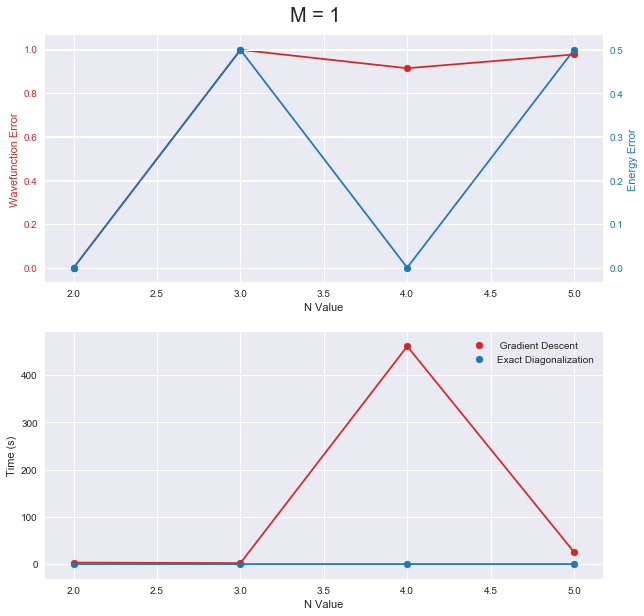

In [63]:
plt.figure(figsize=(10,10))
ttl = plt.suptitle("M = 1",size =20)
ttl.set_position([.5, 0.92])
ax1 = plt.subplot(2,1,1)

color = 'tab:red'
ax1.set_xlabel('N Value')
ax1.set_ylabel('Wavefunction Error', color=color)
ax1.plot(N_values, M1stateErr,color=color)
ax1.scatter(N_values, M1stateErr,color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Energy Error', color=color)  
ax2.plot(N_values, M1engErr, color=color)
ax2.scatter(N_values, M1engErr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = plt.subplot(2,1,2)

color = 'tab:red'
ax3.set_xlabel('N Value')
ax3.set_ylabel('Time (s)')
ax3.plot(N_values, M1gdTime,color=color)
ax3.scatter(N_values, M1gdTime,color=color, label = ' Gradient Descent')
color = 'tab:blue'
ax3.plot(N_values, M1edTime, color=color)
ax3.scatter(N_values, M1edTime, color=color, label = 'Exact Diagonalization')
ax3.legend()
plt.show()

In [52]:
#Parameter definition 
N_values = np.arange(2,6)
M=2
B = 0
A0 = 1
M2gdResults = []
M2gdTime = []
M2edResults = []
M2edTime = []
M2engErr = []
M2stateErr = []

In [53]:
#vary N value
for i in range(N_values.size):
    #gradient descent
    gradDescent = GradDescent(N_values[i], B, A0)
    gd = gradDescent(N_values[i], M)
    M2gdResults.append(gd[0])
    M2gdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N_values[i],B,A0)
    ed = groundState()
    M2edResults.append(ed[0])
    M2edTime.append(ed[1])
    
    #Error
    gdEng = gd[0][2]
    edEng = ed[0][0]
    gdState = gd[0][1]
    edState = ed[0][1]
    errTemp = err(gdState,edState,gdEng,edEng)
    M2engErr.append(errTemp[0])
    M2stateErr.append(errTemp[1])


Optimization terminated successfully.
         Current function value: -0.749998
         Iterations: 18
         Function evaluations: 756
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 71
         Function evaluations: 3840
         Gradient evaluations: 160
Optimization terminated successfully.
         Current function value: -1.249971
         Iterations: 225
         Function evaluations: 15270
         Gradient evaluations: 509
Optimization terminated successfully.
         Current function value: -0.999999
         Iterations: 8
         Function evaluations: 1224
         Gradient evaluations: 34


In [54]:
print('Gradient Descent Time: ', M2gdTime)
print('Exact Diagonalization Time: ', M2edTime)
print('Energy Energy: ', M2engErr)
print('Wavefunction Energy: ', M2stateErr)

Gradient Descent Time:  [4.284958600997925, 38.23074126243591, 302.82313799858093, 50.90234899520874]
Exact Diagonalization Time:  [0.000997304916381836, 0.0009975433349609375, 0.0019948482513427734, 0.0]
Energy Energy:  [1.5220764469914272e-06, 2.492101085493914e-07, 2.9032103979531598e-05, 0.5000005646615946]
Wavefunction Energy:  [7.610385129863673e-07, 0.1265094979563891, 0.8916680082059257, 0.9729541976634558]


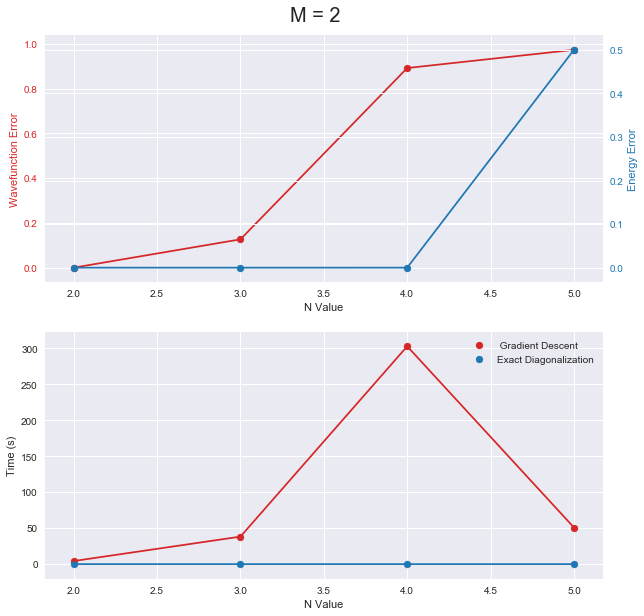

In [55]:
plt.figure(figsize=(10,10))
ttl = plt.suptitle("M = 2",size =20)
ttl.set_position([.5, 0.92])
ax1 = plt.subplot(2,1,1)

color = 'tab:red'
ax1.set_xlabel('N Value')
ax1.set_ylabel('Wavefunction Error', color=color)
ax1.plot(N_values, M2stateErr,color=color)
ax1.scatter(N_values, M2stateErr,color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Energy Error', color=color)  
ax2.plot(N_values, M2engErr, color=color)
ax2.scatter(N_values, M2engErr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = plt.subplot(2,1,2)

color = 'tab:red'
ax3.set_xlabel('N Value')
ax3.set_ylabel('Time (s)')
ax3.plot(N_values, M2gdTime,color=color)
ax3.scatter(N_values, M2gdTime,color=color, label = ' Gradient Descent')
color = 'tab:blue'
ax3.plot(N_values, M2edTime, color=color)
ax3.scatter(N_values, M2edTime, color=color, label = 'Exact Diagonalization')
ax3.legend()
plt.show()

In [56]:
#Parameter definition 
N_values = np.arange(2,6)
M=3
B = 0
A0 = 1
M3gdResults = []
M3gdTime = []
M3edResults = []
M3edTime = []
M3engErr = []
M3stateErr = []

In [57]:
#vary N value
for i in range(N_values.size):
    #gradient descent
    gradDescent = GradDescent(N_values[i], B, A0)
    gd = gradDescent(N_values[i], M)
    M3gdResults.append(gd[0])
    M3gdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N_values[i],B,A0)
    ed = groundState()
    M3edResults.append(ed[0])
    M3edTime.append(ed[1])
    
    #Error
    gdEng = gd[0][2]
    edEng = ed[0][0]
    gdState = gd[0][1]
    edState = ed[0][1]
    errTemp = err(gdState,edState,gdEng,edEng)
    M3engErr.append(errTemp[0])
    M3stateErr.append(errTemp[1])


C:\Users\aorfi\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in cdouble_scalars
C:\Users\aorfi\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in cdouble_scalars
C:\Users\aorfi\Anaconda3\envs\qutip-env\lib\site-packages\scipy\sparse\data.py:123: RuntimeWarning: invalid value encountered in multiply
  return self._with_data(self.data * other)
C:\Users\aorfi\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in cosh
C:\Users\aorfi\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in cdouble_scalars
C:\Users\aorfi\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp
C:\Users\aorfi\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in cdouble

Optimization terminated successfully.
         Current function value: nan
         Iterations: 3
         Function evaluations: 3072
         Gradient evaluations: 128
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 37
         Function evaluations: 2176
         Gradient evaluations: 68
Optimization terminated successfully.
         Current function value: -0.749984
         Iterations: 4
         Function evaluations: 840
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: -1.499945
         Iterations: 281
         Function evaluations: 34896
         Gradient evaluations: 727


In [58]:
print('Gradient Descent Time: ', M3gdTime)
print('Exact Diagonalization Time: ', M3edTime)
print('Energy Energy: ', M3engErr)
print('Wavefunction Energy: ', M3stateErr)

Gradient Descent Time:  [20.389982223510742, 23.20232367515564, 16.833589792251587, 1455.31635928154]
Exact Diagonalization Time:  [0.000997304916381836, 0.0009686946868896484, 0.000997781753540039, 0.0009975433349609375]
Energy Energy:  [nan, 1.0466832034428108e-07, 0.5000158209979911, 5.4999210918005303e-05]
Wavefunction Energy:  [nan, 0.34681413158087593, 0.9584570611502108, 0.9611373125691967]


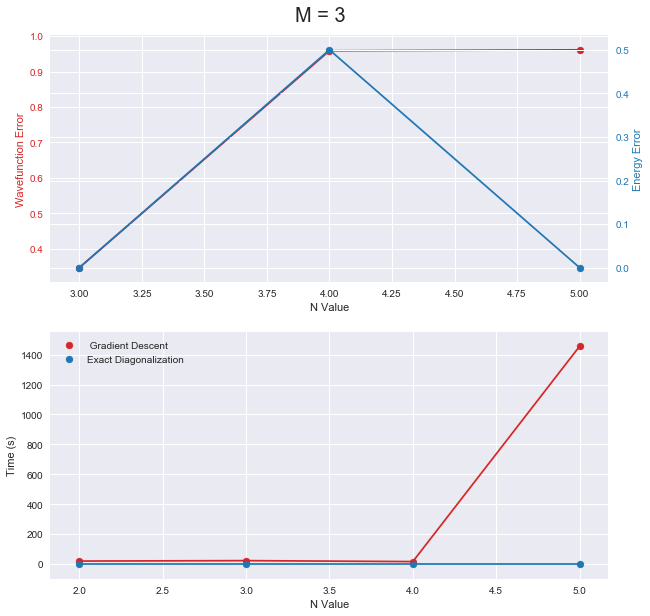

In [59]:
plt.figure(figsize=(10,10))
ttl = plt.suptitle("M = 3",size =20)
ttl.set_position([.5, 0.92])
ax1 = plt.subplot(2,1,1)

color = 'tab:red'
ax1.set_xlabel('N Value')
ax1.set_ylabel('Wavefunction Error', color=color)
ax1.plot(N_values, M3stateErr,color=color)
ax1.scatter(N_values, M3stateErr,color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Energy Error', color=color)  
ax2.plot(N_values, M3engErr, color=color)
ax2.scatter(N_values, M3engErr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = plt.subplot(2,1,2)

color = 'tab:red'
ax3.set_xlabel('N Value')
ax3.set_ylabel('Time (s)')
ax3.plot(N_values, M3gdTime,color=color)
ax3.scatter(N_values, M3gdTime,color=color, label = ' Gradient Descent')
color = 'tab:blue'
ax3.plot(N_values, M3edTime, color=color)
ax3.scatter(N_values, M3edTime, color=color, label = 'Exact Diagonalization')
ax3.legend()
plt.show()